In [1]:
using RData, LightGraphs, Colors, Missings, DataFrames, Gadfly, Plots, CSV, Compose
include("code/BGSM_general.jl");
include("code/model_selection.jl");

INFO: Recompiling stale cache file /Users/yosikim/.julia/lib/v0.6/TimeZones.ji for module TimeZones.
INFO: Recompiling stale cache file /Users/yosikim/.julia/lib/v0.6/RData.ji for module RData.
INFO: Recompiling stale cache file /Users/yosikim/.julia/lib/v0.6/CSV.ji for module CSV.


In [2]:
finaldata = CSV.read("chicagocrime.txt", delim = ' ');

In [ ]:
# data preprocessing
# DO NOT RUN, this is just to show how the data is preprocessed

data = CSV.read("/Users/yosikim/Downloads/chicagocrime.csv", delim = ',');
data1 = data[:,[3;12;14;16;17;18;20;21]];
data1[:Month] = 0;
for i = 1:size(data1,1)
    data1[:Month][i] = (Int(data1[:Date][i][1]) - 48) * 10 + Int(data1[:Date][i][2]) - 48
end
nonnull = find((ismissing.(data1[:Month]) .== false) .& (ismissing.(data1[:Year]) .== false)
                .& (ismissing.(data1[:Community_Area]) .== false) .& (ismissing.(data1[:District]) .== false)
                .& (ismissing.(data1[:Latitude]) .== false) .& (ismissing.(data1[:Longitude]) .== false)
               );
data2 = data1[nonnull,:];
community = Array{Int}(data2[:Community_Area]);
district = Array{Int}(data2[:District]);
disappeared_district = find((data2[:District] .!= 13) .& (data2[:District] .!= 21)
                       .& (data2[:District] .!= 23) .& (data2[:District] .!= 31));
data3 = data2[disappeared_district,:];
finalind = find((data3[:X_Coordinate] .> 0) .& (data3[:Y_Coordinate] .> 0));
finaldata = data3[finalind,:];

In [3]:
# see how data look like
finaldata[:Season] = finaldata[:Year] + floor.(finaldata[:Month]/3)/4;
head(finaldata)

6×10 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row │ Date                   │ District │ Community_Area │ X_Coordinate │
├─────┼────────────────────────┼──────────┼────────────────┼──────────────┤
│ 1   │ 03/18/2015 07:44:00 PM │ 11       │ 25             │ 1144606      │
│ 2   │ 03/18/2015 11:00:00 PM │ 7        │ 67             │ 1166468      │
│ 3   │ 03/18/2015 10:45:00 PM │ 2        │ 39             │ 1185075      │
│ 4   │ 03/18/2015 10:30:00 PM │ 2        │ 40             │ 1178033      │
│ 5   │ 03/18/2015 09:00:00 PM │ 11       │ 25             │ 1144920      │
│ 6   │ 03/18/2015 10:00:00 PM │ 2        │ 39             │ 1183018      │

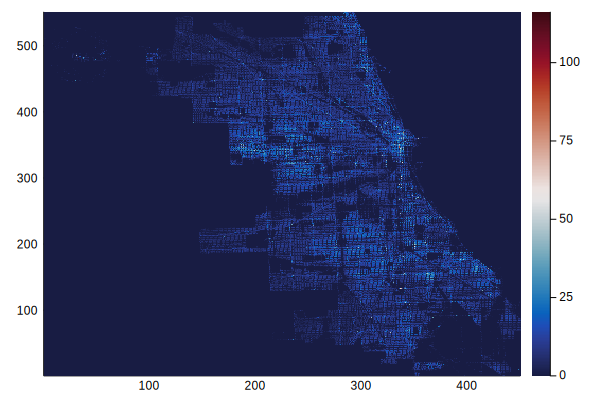

In [57]:
lati = floor.(Int,finaldata[:Y_Coordinate]/10^3 * 4 + 0.5); lati = lati - minimum(lati) + 1;
long = floor.(Int,finaldata[:X_Coordinate]/10^3 * 4 + 0.5); long = long - minimum(long) + 1;
n1 = maximum(lati); n2 = maximum(long);
z = zeros(n1*n2); w = zeros(n1*n2); v = zeros(n1,n2);
for i = 1:length(lati)
    ind = (lati[i] - 1) * n2 + long[i];
    z[ind] += 1;
    w[ind] = finaldata[:District][i];
    v[ind] = finaldata[:Community_Area][i];
end
Z = reshape(z,n2,n1)';
W = reshape(w,n2,n1)';
V = reshape(v,n2,n1)';
Y = sqrt.(Z);
heatmap(Y, fillcolor = :balance)

In [58]:
district_name = ["1st District – Central";
"2nd District – Wentworth";
"3rd District – Grand Crossing";
"4th District – South Chicago";
"5th District – Calumet";
"6th District – Gresham";
"7th District – Englewood";
"8th District – Chicago Lawn";
"9th District – Deering";
"10th District – Ogden";
"11th District – Harrison";
"12th District – Near West";
"14th District – Shakespeare";
"15th District – Austin";
"16th District – Jefferson Park";
"17th District – Albany Park";
"18th District – Near North";
"19th District – Town Hall";
"20th District – Lincoln";
"22nd District – Morgan Park";
"24th District – Rogers Park";
"25th District – Grand Central";];

year = sort(unique(finaldata[:Season]))
district_enumerate = sort(unique(finaldata[:District]));
district_mean = zeros(length(district_name),length(year));
district_sum = zeros(length(district_name),length(year));
district_num = zeros(length(district_name));

for i = 1:length(district_name)
    district_num[i] = sum(W .== district_enumerate[i]);
    ind = findin(finaldata[:District], district_enumerate[i]);
    for j = 1:length(year)
        district_sum[i,j] = sum(finaldata[:Season][ind] .== year[j]);
        district_mean[i,j] = district_sum[i,j]/district_num[i];
    end
end

#community_name = 0:77;

#community_enumerate = sort(unique(finaldata[:Community_Area]));
#community_mean = zeros(length(community_name),length(year));
#community_sum = zeros(length(community_name),length(year));
#community_num = zeros(length(community_name));

#for i = 1:length(community_name)
#    community_num[i] = sum(V .== community_enumerate[i]);
#    ind = findin(finaldata[:Community_Area], community_enumerate[i]);
#    for j = 1:length(year)
#        community_sum[i,j] = sum(finaldata[:Season][ind] .== year[j]);
#        community_mean[i,j] = community_sum[i,j]/community_num[i];
#    end
#end

In [59]:
y = reshape(sum(reshape(district_mean[:,3:70]',4,17*22),1)[:],17,22)';
df2 = DataFrame(y = y[:] * 4,
    m = (y ./ mean(y,1) * mean(y))[:] * 4,
    district = repeat(district_name, outer = 17),
    year = repeat(2002:2018, inner = 22));

In [60]:
df = DataFrame(y = district_sum[:],
    m = district_mean[:],
    district = repeat(district_name, outer = length(year)),
    year = repeat(year, inner = length(district_name)));
ind = find((df[:year] .>= 2003) .& (df[:year] .<= 2017.75))
df1 = df[ind,:];
x = 2003:0.25:2017.75;
y = mean(district_mean[:,9:end-3],1)[:];
beta = (y - mean(y))'*(x - mean(x))/norm(x - mean(x))^2;
correct = beta * x + mean(y) - beta * mean(x);
df1[:c] = df1[:m] - repeat(correct, inner = 22)[:];
yearlymean = mean(reshape(district_sum[:,9:68],88,15),1)[:];
df1[:r] = df1[:m] ./ repeat(yearlymean, inner = 88) * sum(yearlymean);

In [132]:
E = copy(W);
for i = 1:22
    E[find(W .== district_enumerate[i])] = i
end
E[find(E .== 0)] = NaN
heatmap(E, color = cgrad(Scale.color_discrete_hue().f(22)), legend = :none, axis = false)
savefig("figure/F20.pdf")

In [106]:
Scale.color_discrete_hue().f(22)[1]

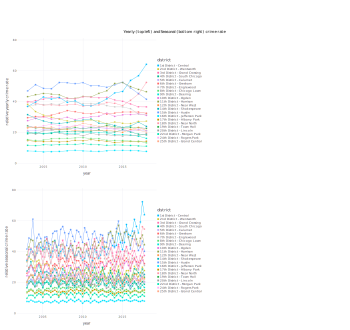

In [138]:
set_default_plot_size(35cm, 33cm)
F1 = Gadfly.plot(df2[23:end,:], x = :year, y = :m, color = :district, Geom.line, Geom.point,
    Coord.Cartesian(xmin = 2002, xmax = 2019),
    Guide.ylabel("relative yearly crime rate"))
F2 = Gadfly.plot(df1, x = :year, y = :r, color = :district, Geom.line, Geom.point,
Coord.Cartesian(xmin = 2002, xmax = 2019), Guide.ylabel("relative seasonal crime rate"))
F = title(vstack(
    compose(context(0, 0cm, 20cm, 15cm), render(F1)), compose(context(0, 0cm, 20cm, 15cm), render(F2))),
    "Yearly (top left) and Seasonal (bottom right) crime rate")
Gadfly.draw(PDF("F15.pdf"), F)
F

In [62]:
g = Graph(22);
add_edge!(g,(1,2)); add_edge!(g,(1,9)); add_edge!(g,(1,12)); add_edge!(g,(1,17));
add_edge!(g,(2,3)); add_edge!(g,(2,7)); add_edge!(g,(2,9));
add_edge!(g,(3,4)); add_edge!(g,(3,6)); add_edge!(g,(3,7));
add_edge!(g,(4,5)); add_edge!(g,(4,6));
add_edge!(g,(5,6));
add_edge!(g,(6,7)); add_edge!(g,(6,8)); add_edge!(g,(6,20));
add_edge!(g,(7,8)); add_edge!(g,(7,9));
add_edge!(g,(8,9)); add_edge!(g,(8,10));
add_edge!(g,(9,10)); add_edge!(g,(9,12));
add_edge!(g,(10,11)); add_edge!(g,(10,12));
add_edge!(g,(11,12)); add_edge!(g,(11,13)); add_edge!(g,(11,14)); add_edge!(g,(11,22));
add_edge!(g,(12,17)); #add_edge!(g,(12,13));
add_edge!(g,(13,18)); add_edge!(g,(13,16)); add_edge!(g,(13,17)); add_edge!(g,(13,22));
add_edge!(g,(14,22));
add_edge!(g,(15,16)); add_edge!(g,(15,22));
add_edge!(g,(16,18)); add_edge!(g,(16,19)); add_edge!(g,(16,21));
add_edge!(g,(17,18));
add_edge!(g,(18,19));
add_edge!(g,(19,21));
h = PathGraph(17);
G = cartesian_product(h, g);

In [63]:
D = -full(incidence_matrix(G, oriented = true))';
out = BGSM_general(df2[:m], D, v0 = 1e-3 * 1.5, v1 = 1e4, b = 22, verbose = false);
out_ms = model_selection(out);
df2[:fit] = out_ms[:t_full];
out_ms[:score]

1366.391028810269

In [139]:
A = copy(W);
for i = 1:22
    A[find(W .== district_enumerate[i])] = reshape(df2[:fit],22,17)[i,end-6]
end
B = copy(W);
for i = 1:22
    B[find(W .== district_enumerate[i])] = reshape(df2[:fit],22,17)[i,end-3]
end
C = copy(W);
for i = 1:22
    C[find(W .== district_enumerate[i])] = reshape(df2[:fit],22,17)[i,end]
end
A[A .== 0] = NaN;
B[B .== 0] = NaN;
C[C .== 0] = NaN;
F1 = heatmap(A, fillcolor = :balance, clim = (0,60), legend = :none, title = "Year of 2011");
F2 = heatmap(B, fillcolor = :balance, clim = (0,60), legend = :none, title = "Year of 2014");
F3 = heatmap(C, fillcolor = :balance, clim = (0,60), title = "Year of 2017");
F = Plots.plot(F1,F2,F3, size = (1800,450), layout = grid(1,3,widths=[0.3,0.3,0.41]), axis = false)
savefig("figure/F14.pdf")

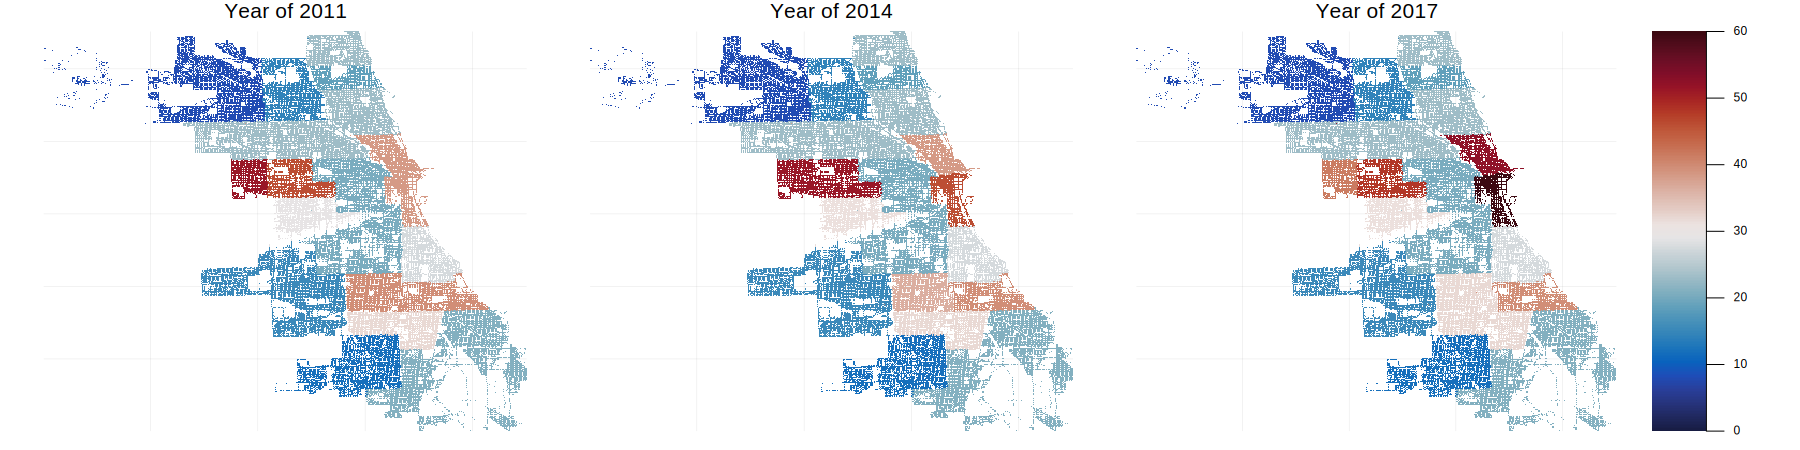

In [140]:
F

In [74]:
function BGSM_cartesian(y, D1, D2;
                        init = y,
                        v0 = 1e-1,
                        v1 = 1e6,
                        c = 0.1,
                        convtol = 1e-14,  
                        iter = 100,
                        verbose = true)
                            
    
    # get size
    n1,n2 = size(y); n1 = Int(n1/4); n = n1 * n2;
    
    # initialize
    theta = copy(y);
    q1 = zeros(size(D1,1)); q2 = zeros(size(D2,1));
    sigmasq1 = 1; sigmasq2 = c;
    m = mean(y);
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = sum((D1*theta[1:22,:]).^2 + (D1*theta[23:44,:]).^2 + (D1*theta[45:66,:]).^2 +
                (D1*theta[67:88,:]).^2,2);
        q1 = 1./( 1 + sqrt(v0/v1) * exp.(d1/2 * (1/v0 - 1/v1)/sigmasq1) );
        
        # E-step: update g2
        d2 = sum((D2*theta').^2,2);
        q2 = 1./( 1 + sqrt(v0/v1) * exp.(d2/2 * (1/v0 - 1/v1)/sigmasq2) );
        
        # M-step: update theta
        L1 = D1' * Diagonal(q1[:]) * D1/v0;
        L2 = D2' * Diagonal(q2[:]) * D2/v0;
        L = kron(L2, speye(22)) + kron(speye(15),L1);
        
        theta = [reshape((speye(n) + L)\y[1:22,:][:], 22,15);
                reshape((speye(n) + L)\y[23:44,:][:], 22,15);
                reshape((speye(n) + L)\y[45:66,:][:], 22,15);
                reshape((speye(n) + L)\y[67:88,:][:], 22,15)];
        
        
        if verbose & (rem(i,5) == 0)
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if verbose & (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            @printf "the algorithm converged at %3d-th iteration: 
                    error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2)
                ])
end

BGSM_cartesian (generic function with 1 method)

In [75]:
D1 = -full(incidence_matrix(g, oriented = true))';
D2 = -full(incidence_matrix(PathGraph(15), oriented = true))';
out2 = BGSM_cartesian(reshape(df1[:r],88,15)/100, D1, D2, v0 = 1e-3 * 7, c = 0.1, iter = 200)

  5-th iteration done: error = 1.52e-05
the algorithm converged at   7-th iteration: 
                    error = 3.77e-20


Dict{Symbol,Array{Float64,2}} with 3 entries:
  :q2    => [1.33466e-11; 0.999916; … ; 7.9691e-13; 5.08619e-14]
  :theta => [0.345377 0.347357 … 0.444124 0.47973; 0.335 0.245225 … 0.216018 0.…
  :q1    => [9.6864e-36; 9.47435e-97; … ; 0.999916; 0.999916]

In [76]:
ind1 = find(out2[:q1] .> 0.5)

# get a thresholded graph
L1 = D1[ind1,:]'*D1[ind1,:];
g1 = Graph((abs.(L1) - L1)/2);
    
# edge contraction / node merger
c1 = connected_components(g1);

ind2 = find(out2[:q2] .> 0.5);
    
# get a thresholded graph
L2 = D2[ind2,:]'*D2[ind2,:];
g2 = Graph((abs.(L2) - L2)/2);
    
# edge contraction / node merger
c2 = connected_components(g2);

df1[:Year] = floor.(df1[:year])
df1[:Season] = ["Winter";"Spring";"Summer";"Fall"][Array{Int}(4 * (df1[:year] - df1[:Year])) + 1];
df1[:fit] = (out2[:theta])[:] * 100;
df1[:Year] = floor.(df1[:year])
df1[:Season] = ["Winter";"Spring";"Summer";"Fall"][Array{Int}(4 * (df1[:year] - df1[:Year])) + 1];
df1[:group] = repeat(["Central(1st,18th)";"South Side(2nd)";"Southwest Side(3rd,6th,7th)";
"Far South Side(4th, 5th)";
"Far South Side(4th, 5th)";"Southwest Side(3rd,6th,7th)";"Southwest Side(3rd,6th,7th)";
"Near Central(8th,9th,12th)";"Near Central(8th,9th,12th)";"Far West Side(10th)";
"Far West Side(11th,15th)"; "Near Central(8th,9th,12th)";"North(14th,19th,20th,24th,25th)";
"Far West Side(11th,15th)";"Far Northwest Side(16th)"; "North(14th,19th,20th,24th,25th)";
"Central(1st,18th)";"North(14th,19th,20th,24th,25th)";"North(14th,19th,20th,24th,25th)";
"Far Southwest Side(22nd)";
"North(14th,19th,20th,24th,25th)";"North(14th,19th,20th,24th,25th)"],outer = 60);

In [339]:
[10;6;8;4;4;8;8;3;3;7;9;3;5;9;1;5;10;5;5;2;5;5]

10-element Array{Int64,1}:
 10
  6
  8
  4
  3
  7
  9
  5
  1
  2

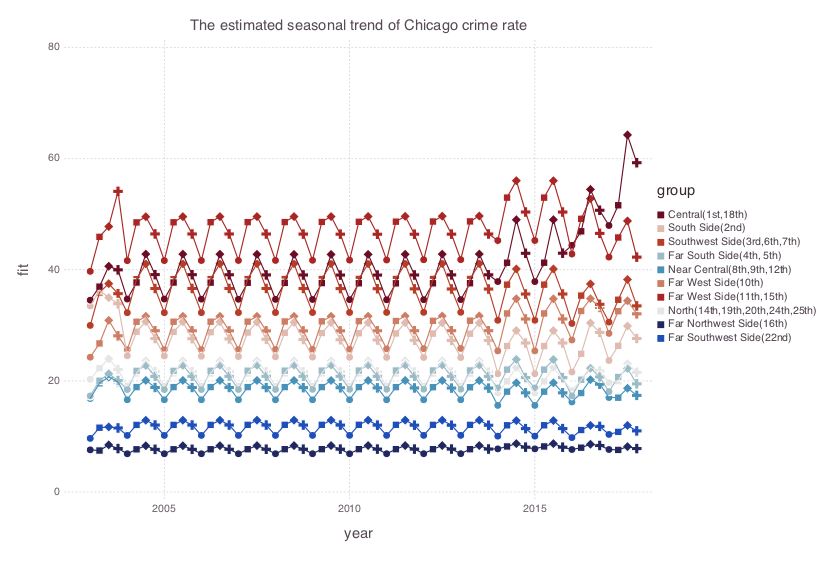

In [346]:
set_default_plot_size(22cm,15cm)
F = Gadfly.plot(df1, x = :year, y = :fit, color = :group, shape = :Season,
    size = repeat([3pt;4pt;4pt;4pt], inner = 22),
    Geom.line, Geom.point,
    Coord.Cartesian(xmin = 2002.5, xmax = 2018),
    Scale.color_discrete_manual(RGB(cgrad(:balance)[28]), RGB(cgrad(:balance)[18]), RGB(cgrad(:balance)[24]),
RGB(cgrad(:balance)[12]), RGB(cgrad(:balance)[9]), RGB(cgrad(:balance)[21]),
RGB(cgrad(:balance)[25]), RGB(cgrad(:balance)[15]), RGB(cgrad(:balance)[2]),
RGB(cgrad(:balance)[5])),
    Guide.title("The estimated seasonal trend of Chicago crime rate"))
Gadfly.draw(PDF("figure/F16.pdf"), F)
F

In [338]:
temp = reshape(df1[:fit], 22, 60)
H = copy(W);
for i = 1:22
    H[find(W .== district_enumerate[i])] = [10;6;8;4;4;8;8;3;3;7;9;3;5;9;1;5;10;5;5;2;5;5][i]
end
H[find(H .== 0)] = NaN
heatmap(H, color = cgrad(:balance), legend = :none, axis = false)
savefig("figure/F18.pdf")

In [336]:
[round.(temp[:,end-1]) sort(round.(temp[:,end-1]))]

22×2 Array{Float64,2}:
 64.0   8.0
 30.0  12.0
 38.0  19.0
 22.0  19.0
 22.0  19.0
 38.0  22.0
 38.0  22.0
 19.0  23.0
 19.0  23.0
 34.0  23.0
 49.0  23.0
 19.0  23.0
 23.0  23.0
 49.0  30.0
  8.0  34.0
 23.0  38.0
 64.0  38.0
 23.0  38.0
 23.0  49.0
 12.0  49.0
 23.0  64.0
 23.0  64.0

In [337]:
[10;6;8;4;4;8;8;3;3;7;9;3;5;9;1;5;10;5;5;2;5;5]

22-element Array{Int64,1}:
 10
  6
  8
  4
  4
  8
  8
  3
  3
  7
  9
  3
  5
  9
  1
  5
 10
  5
  5
  2
  5
  5

In [298]:
RGB(cgrad(:balance)[1])
RGB(cgrad(:balance)[61])